In [1]:
import numpy as np
import pandas as pd
import pickle
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# import from scripts
import os
current_wd = os.getcwd()
os.chdir(os.path.abspath("..\\..\\..\\isttc\\scripts"))
from calculate_tau import fit_single_exp, fit_single_exp_2d, func_single_exp_monkey
from cfg_global import project_folder_path
os.chdir(current_wd)

In [2]:
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'

In [3]:
# True - calc and plot, False only plot
calc_taus = False
save_taus = False
save_fig = False

In [4]:
def calc_population_tau_2d(acf_df_, acf_cols_, start_idx_, func_to_fit_, verbose_=False):
    rows_with_nans_df = acf_df_[acf_df_.isna().any(axis=1)]
    n_rows_with_nan = len(rows_with_nans_df)
    if n_rows_with_nan > 0:
        print(f'N rows with NaNs {n_rows_with_nan}')
    acf_df_.dropna(inplace=True)
    
    acf_2d = acf_df_[acf_cols_].values
    fit_popt, fit_pcov, tau, tau_ci, fit_r_squared, explained_var, log_message = fit_single_exp_2d(acf_2d, start_idx_, func_to_fit_)
    if verbose_:
        print(f'tau {tau*50}, 95% CI {tau_ci[0]*50},{tau_ci[1]*50}')
    return {'tau_ms':tau*50,
            'tau_lower_ms':tau_ci[0]*50, 
            'tau_upper_ms':tau_ci[1]*50, 
            'fit_r_squared': fit_r_squared, 
            'explained_var': explained_var, 
            'popt': fit_popt,
            'n_acfs': len(acf_df_)}

def get_method_tau_dict(areas_, acf_df_, acf_cols_, verbose_=False):
    taus_dict = {}
    for area in areas_:
        if verbose_:
            print(f'processing area {area}')
        acf_df_area = acf_df_.query('ecephys_structure_acronym == @area').copy()
        if verbose_:
            print(f'N units for brain area {area}: {len(acf_df_area)}')
        taus_dict[area] = calc_population_tau_2d(acf_df_area, acf_cols_, 2, func_single_exp_monkey)
    return taus_dict

In [5]:
def get_taus_for_df(acf_full_df_):
    n_lags = 20
    acf_cols = ['acf_' + str(i) for i in range(n_lags)]
    # print('acf_cols {}'.format(acf_cols))

    # acf_df = pd.read_pickle(acf_full_df_file_)
    acf_df = acf_full_df_
    n_rows_with_nan = len(acf_df[acf_df.isna().any(axis=1)])
    # print(f'n_rows_with_nan acf_df {n_rows_with_nan}')

    brain_areas = acf_df['ecephys_structure_acronym'].unique()
    # print(f'brain_areas {brain_areas}')
    
    acf_taus_dict = get_method_tau_dict(brain_areas, acf_df, acf_cols)

    return acf_taus_dict

In [6]:
def get_plot_df(acf_dict, areas, method):
    tau = [acf_dict.get(c, {'tau_ms': np.nan})['tau_ms'] for c in areas]
    tau_lower = [acf_dict.get(c, {'tau_lower_ms': np.nan})['tau_lower_ms'] for c in areas]
    tau_upper = [acf_dict.get(c, {'tau_upper_ms': np.nan})['tau_upper_ms'] for c in areas]
    
    plot_df = pd.DataFrame({'area': areas, 
                                     'tau': tau,
                                     'tau_lower': tau_lower, 
                                     'tau_upper': tau_upper, 
                                     'method': method})
    return plot_df

In [7]:
def calculate_acf_decline_flag(acf_, start_idx=1, end_idx=4):
    acf_decay = np.all(np.diff(acf_[start_idx:end_idx]) <= 0)
    return acf_decay
    
def get_trials_plot_df(trial_dict_, method_, n_iteration_=None):
    n_lags = 20
    acf_cols = ['acf_' + str(i) for i in range(n_lags)]
    
    records = []
    acf_l = []
    idx_ = 0
    for unit_id, data in trial_dict_.items():
        taus = data['taus']
        acfs = data['acf']

        if n_iteration_ is not None:
            # only one trial per unit
            idx = n_iteration_[idx_]
            taus_to_iter = [(taus[idx], acfs[idx])]
        else:
            # all trials for this unit
            taus_to_iter = zip(taus, acfs)

        for tau_dict, acf_array in taus_to_iter:
            records.append({
                'unit_id': unit_id,
                'tau': tau_dict['tau'],
                'fit_r_squared': tau_dict['fit_r_squared'],
                'decline_150_250': calculate_acf_decline_flag(acf_array, start_idx=2, end_idx=4),
                'method': method_,
            })
            acf_l.append(acf_array)
        idx_ = idx_ + 1

    df = pd.DataFrame.from_records(records)
    df['tau_ms'] = df['tau'] * 50

    nan_count = df.isna().any(axis=1).sum()
    if nan_count > 0:
        print(f'N rows with NaNs {nan_count}')

    acfs_df = pd.DataFrame(np.asarray(acf_l), columns=acf_cols)
    acfs_df['unit_id'] = df['unit_id']
    acfs_df.reset_index(inplace=True, drop=True)

    return df, acfs_df

In [8]:
# min_to_keep = 20

dataset_folder = project_folder_path + 'results\\mice\\dataset\\'
fig_folder = project_folder_path + 'results\\mice\\fig_draft_paper\\'

### Load data (or calc)

In [9]:
brain_areas_axes_ticks = ['LGd', 'VISp', 'VISl', 'VISrl', 'LP', 'VISal', 'VISpm', 'VISam']
brain_areas_names = ['LGN', 'V1', 'LM', 'RL', 'LP', 'AL', 'PM', 'AM']

In [10]:
with open(dataset_folder + 'cut_30min\\area_taus_dict.json', 'r') as f:
    area_taus_dict_30 = json.load(f)

area_taus_dict_30.keys()

dict_keys(['acf_full', 'isttc_full', 'pearsonr_trial_avg', 'sttc_trial_avg', 'sttc_trial_concat', 'pearsonr_trial_avg_mean', 'sttc_trial_avg_mean', 'sttc_trial_concat_mean', 'pearsonr_trial_avg_random', 'sttc_trial_avg_random', 'sttc_trial_concat_random'])

In [11]:
units_info_df = pd.read_pickle(dataset_folder + 'cut_30min\\sua_list_constrained_units_df_temp.pkl')
units_info_df_subset = units_info_df[['unit_id', 'ecephys_structure_acronym']].copy()
units_info_df_subset.head(2)

,unit_id,ecephys_structure_acronym
66,950913540,VISam
67,950915005,VISam


In [12]:
pearsontr_40_file = dataset_folder + 'cut_30min\\binned\\pearsonr_trial_avg_50ms_20lags_dict.pkl'
pearsontr_trial_acf_40_dict = pd.read_pickle(pearsontr_40_file)
random_trials_impl = np.zeros(len(pearsontr_trial_acf_40_dict)).astype(int)
pearsontr_trial_avg_plot_40_df, pearsontr_trial_acf_40_df = get_trials_plot_df(pearsontr_trial_acf_40_dict, 'pearsonr_trial_avg', random_trials_impl)
pearsontr_trial_acf_40_df = pearsontr_trial_acf_40_df.merge(units_info_df_subset, on='unit_id', how='inner')

pearsontr_60_file = dataset_folder + 'cut_30min\\binned\\pearsonr_trial_avg_50ms_20lags_60trials_dict.pkl'
pearsontr_trial_acf_60_dict = pd.read_pickle(pearsontr_60_file)
random_trials_impl = np.zeros(len(pearsontr_trial_acf_60_dict)).astype(int)
pearsontr_trial_avg_plot_60_df, pearsontr_trial_acf_60_df = get_trials_plot_df(pearsontr_trial_acf_60_dict, 'pearsonr_trial_avg', random_trials_impl)
pearsontr_trial_acf_60_df = pearsontr_trial_acf_60_df.merge(units_info_df_subset, on='unit_id', how='inner')

pearsontr_80_file = dataset_folder + 'cut_30min\\binned\\pearsonr_trial_avg_50ms_20lags_80trials_dict.pkl'
pearsontr_trial_acf_80_dict = pd.read_pickle(pearsontr_80_file)
random_trials_impl = np.zeros(len(pearsontr_trial_acf_80_dict)).astype(int)
pearsontr_trial_avg_plot_80_df, pearsontr_trial_acf_80_df = get_trials_plot_df(pearsontr_trial_acf_80_dict, 'pearsonr_trial_avg', random_trials_impl)
pearsontr_trial_acf_80_df = pearsontr_trial_acf_80_df.merge(units_info_df_subset, on='unit_id', how='inner')

pearsontr_100_file = dataset_folder + 'cut_30min\\binned\\pearsonr_trial_avg_50ms_20lags_100trials_dict.pkl'
pearsontr_trial_acf_100_dict = pd.read_pickle(pearsontr_100_file)
random_trials_impl = np.zeros(len(pearsontr_trial_acf_100_dict)).astype(int)
pearsontr_trial_avg_plot_100_df, pearsontr_trial_acf_100_df = get_trials_plot_df(pearsontr_trial_acf_100_dict, 'pearsonr_trial_avg', random_trials_impl)
pearsontr_trial_acf_100_df = pearsontr_trial_acf_100_df.merge(units_info_df_subset, on='unit_id', how='inner')

N rows with NaNs 995
N rows with NaNs 677
N rows with NaNs 491
N rows with NaNs 385


In [13]:
isttc_40_file = dataset_folder + 'cut_30min\\non_binned\\sttc_trial_concat_50ms_20lags_dict.pkl'
isttc_acf_40_dict = pd.read_pickle(isttc_40_file)
random_trials_impl = np.zeros(len(isttc_acf_40_dict)).astype(int)
isttc_plot_40_df, isttc_acf_40_df = get_trials_plot_df(isttc_acf_40_dict, 'isttc_trial_concat', random_trials_impl)
isttc_acf_40_df = isttc_acf_40_df.merge(units_info_df_subset, on='unit_id', how='inner')

isttc_60_file = dataset_folder + 'cut_30min\\non_binned\\sttc_trial_concat_50ms_20lags_60trials_dict.pkl'
isttc_acf_60_dict = pd.read_pickle(isttc_60_file)
random_trials_impl = np.zeros(len(isttc_acf_60_dict)).astype(int)
isttc_plot_60_df, isttc_acf_60_df = get_trials_plot_df(isttc_acf_60_dict, 'isttc_trial_concat', random_trials_impl)
isttc_acf_60_df = isttc_acf_60_df.merge(units_info_df_subset, on='unit_id', how='inner')

isttc_80_file = dataset_folder + 'cut_30min\\non_binned\\sttc_trial_concat_50ms_20lags_80trials_dict.pkl'
isttc_acf_80_dict = pd.read_pickle(isttc_80_file)
random_trials_impl = np.zeros(len(isttc_acf_80_dict)).astype(int)
isttc_plot_80_df, isttc_acf_80_df = get_trials_plot_df(isttc_acf_80_dict, 'isttc_trial_concat', random_trials_impl)
isttc_acf_80_df = isttc_acf_80_df.merge(units_info_df_subset, on='unit_id', how='inner')

isttc_100_file = dataset_folder + 'cut_30min\\non_binned\\sttc_trial_concat_50ms_20lags_100trials_dict.pkl'
isttc_acf_100_dict = pd.read_pickle(isttc_100_file)
random_trials_impl = np.zeros(len(isttc_acf_100_dict)).astype(int)
isttc_plot_100_df, isttc_acf_100_df = get_trials_plot_df(isttc_acf_100_dict, 'isttc_trial_concat', random_trials_impl)
isttc_acf_100_df = isttc_acf_100_df.merge(units_info_df_subset, on='unit_id', how='inner')

In [14]:
area_taus_dict = {'acf_full_40': get_taus_for_df(pearsontr_trial_acf_40_df), 
                  'isttc_full_40': get_taus_for_df(isttc_acf_40_df),
                  'acf_full_60': get_taus_for_df(pearsontr_trial_acf_60_df), 
                  'isttc_full_60': get_taus_for_df(isttc_acf_60_df),
                  'acf_full_80': get_taus_for_df(pearsontr_trial_acf_80_df), 
                  'isttc_full_80': get_taus_for_df(isttc_acf_80_df),
                  'acf_full_100': get_taus_for_df(pearsontr_trial_acf_80_df), 
                  'isttc_full_100': get_taus_for_df(isttc_acf_100_df)}

N rows with NaNs 158
N rows with NaNs 27
N rows with NaNs 236
N rows with NaNs 142
N rows with NaNs 4
N rows with NaNs 172
N rows with NaNs 138
N rows with NaNs 118
N rows with NaNs 104
N rows with NaNs 16
N rows with NaNs 186
N rows with NaNs 98
N rows with NaNs 106
N rows with NaNs 84
N rows with NaNs 83
N rows with NaNs 69
N rows with NaNs 12
N rows with NaNs 131
N rows with NaNs 67
N rows with NaNs 78
N rows with NaNs 74
N rows with NaNs 60
N rows with NaNs 69
N rows with NaNs 12
N rows with NaNs 131
N rows with NaNs 67
N rows with NaNs 78
N rows with NaNs 74
N rows with NaNs 60


In [15]:
tau_acf_full_30_df = get_plot_df(area_taus_dict_30['acf_full'], brain_areas_axes_ticks, 'acf_full')
tau_acf_full_30_df['duration_min'] = 30
tau_acf_full_30_df['tau_diff'] = tau_acf_full_30_df['tau'] - tau_acf_full_30_df['tau']
tau_isttc_full_30_df = get_plot_df(area_taus_dict_30['isttc_full'], brain_areas_axes_ticks, 'isttc_full')
tau_isttc_full_30_df['duration_min'] = 30
tau_isttc_full_30_df['tau_diff'] = tau_isttc_full_30_df['tau'] - tau_isttc_full_30_df['tau']

tau_pearsonr_40_df = get_plot_df(area_taus_dict_30['pearsonr_trial_avg_random'], brain_areas_axes_ticks, 'pearsonr_trial_avg')
tau_pearsonr_40_df['n_trials'] = 40
tau_pearsonr_40_df['tau_diff'] = tau_pearsonr_40_df['tau'] - tau_acf_full_30_df['tau']
tau_isttc_40_df = get_plot_df(area_taus_dict_30['sttc_trial_concat_random'], brain_areas_axes_ticks, 'sttc_trial_concat')
tau_isttc_40_df['n_trials'] = 40
tau_isttc_40_df['tau_diff'] = tau_isttc_40_df['tau'] - tau_isttc_full_30_df['tau'] 

tau_pearsonr_60_df = get_plot_df(area_taus_dict['acf_full_60'], brain_areas_axes_ticks, 'pearsonr_trial_avg')
tau_pearsonr_60_df['n_trials'] = 60
tau_pearsonr_60_df['tau_diff'] = tau_pearsonr_60_df['tau'] - tau_acf_full_30_df['tau']
tau_isttc_60_df = get_plot_df(area_taus_dict['isttc_full_60'], brain_areas_axes_ticks, 'sttc_trial_concat')
tau_isttc_60_df['n_trials'] = 60
tau_isttc_60_df['tau_diff'] = tau_isttc_60_df['tau'] - tau_isttc_full_30_df['tau'] 

tau_pearsonr_80_df = get_plot_df(area_taus_dict['acf_full_80'], brain_areas_axes_ticks, 'pearsonr_trial_avg')
tau_pearsonr_80_df['n_trials'] = 80
tau_pearsonr_80_df['tau_diff'] = tau_pearsonr_80_df['tau'] - tau_acf_full_30_df['tau']
tau_isttc_80_df = get_plot_df(area_taus_dict['isttc_full_80'], brain_areas_axes_ticks, 'sttc_trial_concat')
tau_isttc_80_df['n_trials'] = 80
tau_isttc_80_df['tau_diff'] = tau_isttc_80_df['tau'] - tau_isttc_full_30_df['tau'] 

tau_pearsonr_100_df = get_plot_df(area_taus_dict['acf_full_100'], brain_areas_axes_ticks, 'pearsonr_trial_avg')
tau_pearsonr_100_df['n_trials'] = 100
tau_pearsonr_100_df['tau_diff'] = tau_pearsonr_100_df['tau'] - tau_acf_full_30_df['tau']
tau_isttc_100_df = get_plot_df(area_taus_dict['isttc_full_100'], brain_areas_axes_ticks, 'sttc_trial_concat')
tau_isttc_100_df['n_trials'] = 100
tau_isttc_100_df['tau_diff'] = tau_isttc_100_df['tau'] - tau_isttc_full_30_df['tau'] 

tau_df = pd.concat([tau_pearsonr_40_df, tau_isttc_40_df, tau_pearsonr_60_df, tau_isttc_60_df, 
                    tau_pearsonr_80_df, tau_isttc_80_df, tau_pearsonr_100_df, tau_isttc_100_df])

tau_df['abs_tau_diff'] = np.abs(tau_df['tau_diff'])
tau_df.reset_index(inplace=True, drop=True)

tau_df

,area,tau,tau_lower,tau_upper,method,n_trials,tau_diff,abs_tau_diff
0,LGd,289.627184,202.230126,377.024243,pearsonr_trial_avg,40,-44.037933,44.037933
1,VISp,318.453961,265.029674,371.878249,pearsonr_trial_avg,40,-1.212915,1.212915
2,VISl,352.053308,276.350352,427.756264,pearsonr_trial_avg,40,42.219839,42.219839
3,VISrl,236.800526,190.589710,283.011341,pearsonr_trial_avg,40,4.840140,4.840140
4,LP,280.205386,233.641592,326.769180,pearsonr_trial_avg,40,22.672231,22.672231
...,...,...,...,...,...,...,...,...
59,VISrl,258.268906,219.058694,297.479119,sttc_trial_concat,100,17.089471,17.089471
60,LP,274.419009,239.829696,309.008322,sttc_trial_concat,100,18.238364,18.238364
61,VISal,351.796644,299.175298,404.417990,sttc_trial_concat,100,34.388507,34.388507
62,VISpm,462.402356,348.753146,576.051566,sttc_trial_concat,100,106.661344,106.661344


In [16]:
tau_acf_full_30_df

,area,tau,tau_lower,tau_upper,method,duration_min,tau_diff
0,LGd,333.665117,263.428446,403.901788,acf_full,30,0.0
1,VISp,319.666876,295.833667,343.500085,acf_full,30,0.0
2,VISl,309.833469,279.672525,339.994413,acf_full,30,0.0
3,VISrl,231.960386,209.990322,253.930450,acf_full,30,0.0
4,LP,257.533155,232.531661,282.534650,acf_full,30,0.0
5,VISal,308.236681,279.836255,336.637108,acf_full,30,0.0
6,VISpm,355.878467,309.013986,402.742948,acf_full,30,0.0
7,VISam,336.073203,299.788364,372.358042,acf_full,30,0.0


In [17]:
tau_pearsonr_40_df

,area,tau,tau_lower,tau_upper,method,n_trials,tau_diff
0,LGd,289.627184,202.230126,377.024243,pearsonr_trial_avg,40,-44.037933
1,VISp,318.453961,265.029674,371.878249,pearsonr_trial_avg,40,-1.212915
2,VISl,352.053308,276.350352,427.756264,pearsonr_trial_avg,40,42.219839
3,VISrl,236.800526,190.589710,283.011341,pearsonr_trial_avg,40,4.840140
4,LP,280.205386,233.641592,326.769180,pearsonr_trial_avg,40,22.672231
5,VISal,304.470630,244.309243,364.632016,pearsonr_trial_avg,40,-3.766052
6,VISpm,359.637478,256.948105,462.326851,pearsonr_trial_avg,40,3.759011
7,VISam,444.666739,333.941925,555.391552,pearsonr_trial_avg,40,108.593536


In [18]:
# if save_taus:
#     class NumpyEncoder(json.JSONEncoder):
#         def default(self, obj):
#             if isinstance(obj, np.ndarray):
#                 return obj.tolist()  # Convert ndarray to list
#             return super().default(obj)
    
#     with open(dataset_folder + 'area_taus_dict.json', 'w') as f:
#         json.dump(area_taus_dict, f, cls=NumpyEncoder, indent=4)  

In [19]:
# with open(dataset_folder + 'area_taus_dict.json', 'r') as f:
#     area_taus_dict = json.load(f)

### Plots

In [20]:
color_pearson_trail_avg = '#f4a91c' 
color_sttc_trail_concat = '#955da2' 

colors = [color_pearson_trail_avg, color_sttc_trail_concat]


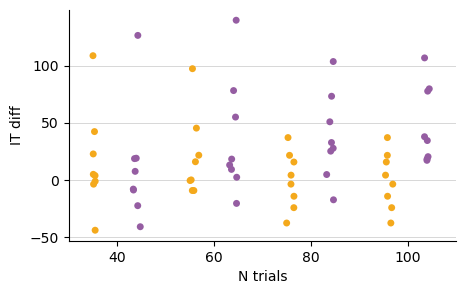

In [21]:
fig, axes = plt.subplots(1, 1, figsize=(5, 3), sharey=False)

sns.stripplot(data=tau_df, x='n_trials', y='tau_diff', hue='method', palette=colors, dodge=True, jitter=True, alpha=1, legend=False, ax=axes)
axes.grid(True, which="both", axis='y', linestyle="-", linewidth=0.5, alpha=0.7)

axes.set_ylabel('IT diff')
axes.set_xlabel('N trials')

#axes.set_ylim([-1, 40])

sns.despine(ax=axes)

if save_fig:
    plt.savefig(fig_folder + 'n_trials_tau.png' , bbox_inches='tight', dpi=300)
    plt.savefig(fig_folder + 'n_trials_tau.svg' , bbox_inches='tight')

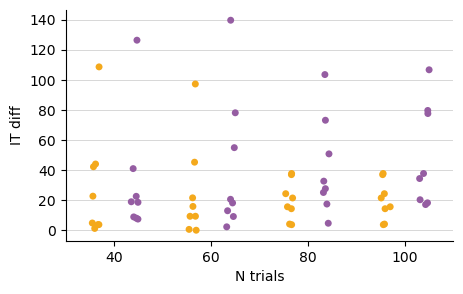

In [22]:
fig, axes = plt.subplots(1, 1, figsize=(5, 3), sharey=False)

sns.stripplot(data=tau_df, x='n_trials', y='abs_tau_diff', hue='method', palette=colors, dodge=True, jitter=True, alpha=1, legend=False, ax=axes)
axes.grid(True, which="both", axis='y', linestyle="-", linewidth=0.5, alpha=0.7)

axes.set_ylabel('IT diff')
axes.set_xlabel('N trials')

#axes.set_ylim([-1, 40])

sns.despine(ax=axes)

save_fig = True
if save_fig:
    plt.savefig(fig_folder + 'n_trials_tau_area.png' , bbox_inches='tight', dpi=300)
    plt.savefig(fig_folder + 'n_trials_tau_area.svg' , bbox_inches='tight')